# [E-11] 프로젝트: 한국어 데이터로 챗봇 만들기

<br>

---

***영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜보자***

***시작 전 주유 라이브러리 버전 확인!!!***

In [217]:
import tensorflow

print(tensorflow.__version__)

2.6.0


## 0) 필요한 라이브러리 임포트하기

In [218]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1) 데이터 수집하기

한국어 챗봇 데이터를 송영숙님이 공개한 챗봇 데이터로 사용한다.

아래 링크를 통해 다운받을 수 있다.

[songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)

In [219]:
path = os.getenv('HOME') + '/aiffel/transformer_chatbot/data'
data = pd.read_csv(os.path.join(path, 'ChatbotData .csv'))

In [220]:
# %%capture
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


여기서 `label`은 0, 1, 2로 분류되어 있다. 각각의 의미는 다음과 같다.<br>

- 0 : 일상다반사<br>
- 1 : 이별(부정)<br>
- 2 : 사랑(긍정)<br>

## 2) 데이터 전처리 하기

- 이번 전처리는 정규 표현식(Regular Expression) 을 사용하여 구두점(punctuation) 을 제거하여 단어를 토크나이징(tokenizing) 하는 일에 방해가 되지 않도록 정제하는 것을 목표로 합니다.

In [221]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  sentence = re.sub(r'�', ' ', sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z?.!,0-9가-힣]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [222]:
questions = []
answers = []

for q, a in zip(data.Q, data.A):
    questions.append(preprocess_sentence(q))
    answers.append(preprocess_sentence(a))


In [223]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.

print('전체 질문 수 :', len(questions))
print('전체 답변 수 :', len(answers))

전체 질문 수 : 11823
전체 답변 수 : 11823


- 임의로 22번째 샘플(인덱스 상으로는 21번 샘플)을 출력해서 질문과 답변이 병렬적으로 잘 저장은 되었는지, 그리고 전처리 함수에서 의도했던 전처리가 진행되었는지 확인해 봅시다!

In [224]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


### 챗봇의 병렬 데이터 전처리하기

1) TensorFlow Datasets **SubwordTextEncoder** 를 토크나이저로 사용한다.<br>단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  각 토큰을 고유한 정수로 인코딩 한다.<br> 
2) 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.<br>
3) 최대 길이 MAX_LENGTH 인 40을 넘는 문장들은 필터링한다.<br>
4) MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩 한다.<br>

#### 1. 단어장(Vocabulary) 만들기
---



우선 각 단어에 고유한 정수 인덱스를 부여하기 위해서 단어장(Vocabulary)을 만들어보겠습니다. 단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용하여 만듭니다.
<br><br>

In [225]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# del tokenizer

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print('슝=3')

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3


In [226]:
tokenizer.vocab_size

8162

디코더의 문장 생성 과정에서 사용할 '시작 토큰'과 '종료 토큰'에 대해서도 임의로 단어장에 추가하여서 정수를 부여해 줍니다. 이미 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기와 그보다 1이 큰 수를 번호로 부여하면 되겠죠?

In [227]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [228]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8162]
END_TOKEN의 번호 : [8163]


두 개의 토큰을 추가해 주었기 때문에 단어장의 크기도 +2임을 명시해 주어야 합니다

In [229]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8164


#### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)
---

위에서 tensorflow_datasets의 SubwordTextEncoder를 사용해서 tokenizer를 정의하고 Vocabulary를 만들었다면, tokenizer.encode()로 각 단어를 정수로 변환할 수 있고 또는 tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있습니다.

<br>예를 들어서 22번째 샘플을 tokenizer.encode()의 입력으로 사용해서 변환 결과를 봅시다.

In [230]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5756, 610, 2486, 4158]
정수 인코딩 후의 21번째 답변 샘플: [2355, 7502, 7, 6266, 97, 1]


In [231]:
print('21번째 질문 정수 인코딩 후 정수 시퀀스를 단어 시퀀스로 변환: {}'.format(tokenizer.decode(tokenizer.encode(questions[21]))))
print('21번째 답변 정수 인코딩 후 정수 시퀀스를 단어 시퀀스로 변환: {}'.format(tokenizer.decode(tokenizer.encode(answers[21]))))

21번째 질문 정수 인코딩 후 정수 시퀀스를 단어 시퀀스로 변환: 가스비 장난 아님
21번째 답변 정수 인코딩 후 정수 시퀀스를 단어 시퀀스로 변환: 다음 달에는 더 절약해봐요 .


각 단어에 고유한 정수가 부여된 Vocabulary를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩된 결과를 확인할 수 있습니다. 위의 결과와 마찬가지로 질문과 답변 셋에 대해서 전부 정수 인코딩 을 수행합니다. 이와 동시에 문장의 최대 길이를 정하고, 해당 길이로 패딩(padding) 합니다.

In [232]:
questions_token = []
answers_token = []
for i in range(len(questions)):
    questions_token.append(tokenizer.encode(questions[i]))
    answers_token.append(tokenizer.encode(answers[i]))

In [233]:
total_data_text = list(questions_token) + list(answers_token)
# 텍스트데이터 문장길이의 리스트를 생성환 후
num_tokens = [len(tokens)+2 for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값 / 최대값 / 표준편차를 계산해본다.
print('문장길이 평균 :', np.mean(num_tokens))
print('문장길이 최대 :', np.max(num_tokens))
print('문장길이 표준편차 :', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 : 7.65169584707773
문장길이 최대 : 31
문장길이 표준편차 : 2.5593138561370665
pad_sequences maxlen :  12
전체 문장의 0.9530153091431954%가 maxlen 설정값 이내에 포함됩니다. 


In [234]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = maxlen
print(MAX_LENGTH)

12


In [235]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 12 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

정수 인코딩 과정을 수행하면서 샘플의 길이가 12를 넘는 경우는 샘플들을 필터링하였으므로 일부 샘플이 제외되었습니다. 단어장의 크기와 샘플의 개수를 확인해 보겠습니다.

In [236]:
questions_token, answers_token = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8164
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


#### 3. 교사 강요(Teacher Forcing) 사용하기
---

`tf.data.Dataset API`는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API이다.<br>이를 적극 활용하기 위해 질문과 답변의 쌍을 `tf.data.Datset`의 입력으로 넣어주는 작업을 한다.<br><br>

이때, 디코더의 입력과 실제(레이블)을 정의해주기 위해서는 **교사강요(Teacher Forcing)**이라는 언어모델의 훈련 기법을 활용한다.

이전 자신의 출력이 현재 자신의 상태를 결정하는 모델을 자기회귀 모델(auto-regressive model, AR) 이라고 합니다. 

질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성합니다. 이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용합니다.

In [237]:
print(questions_token.shape)
print(answers_token.shape)

(10746, 12)
(10746, 12)


In [238]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions_token,
        'dec_inputs': answers_token[:, :-1]
    },
    {
        'outputs': answers_token[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 3) 모델 정의 및 학습하기

### (1) Positional Encoding Layer 구현
---

- 트랜스포머 또한 다른 모델들과 같이 텍스트를 임베딩 벡터로 변환하는 벡터화 과정을 거친다.
- But, 한가지 다른점은 임베딩 벡터에 어떤 값을 더해준 뒤에 입력으로 사용한다. >> `포지셔널 인코딩(positional Encoding)`

<br>

- 트랜스포머는 입력을 받을 때, 문장의 단어들을 1개씩 순차적으로 받는게 아니라, 모든 단어를 한꺼번에 입력으로 받기 때문..
<br>

<br>
`RNN`은 문장을 구성하는 단어들이 어순대로 모델에 입력된다. 따라서 모델에게 따로 어순 정보를 알려줄 필요가 없다.<br>
    `트랜스포머`는 문장에 있는 모든 단어를 한꺼번에 문장 단위로 입력받는다. 따라서 I ate lunch와 lunch ate I를 구분할 수 없다.

**따라서 임베딩 벡터에다가 위치정보를 가진 벡터(positional Encoding)값을 더해서 모델의 입력으로 삼는다.**

In [239]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

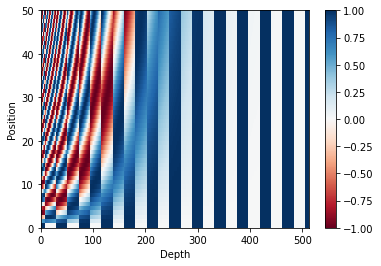

In [240]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#### 어텐션이란?

- 어텐션 메커니즘


- 어텐션 함수에 사용되는 쿼리(Query), 키(Key), 값(Value)는 기본적으로 **`단어 정보를 함축한 벡터`**이다.<br>여기서 **`단어 벡터`**란 초기 입력으로 사용되었던 임베딩 벡터가 아니고, 트랜스포머의 여러 연산을 거친 후의 단어벡터이다.<br><br>

- **인코더 셀프 어텐션** : 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구한다.
- **디코더 셀프 어텐션** : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.
- **인고더-디코더 어텐션** : 디코더가 잘 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.

#### 셀프 어텐션(Self Attention)

- **셀프어텐션이란?** 유사도를 구하는 대상이 다른 문장의 단어가 아니라 ***현재 문장 내의 단어들이 서로 유사도를 구하는 경우를 말한다.***

### (2) 스케일드 닷 프로덕트 어텐션 구현
---

- ***어텐션은 단어들 간의 유사도를 구하는 메커니즘***<br>

- 트랜스포머에서 어텐션 값을 구하는 방법(Q, K, V)


Attention(Q, K, V) = softmax(QK.T/sqrt(dk))*V

In [241]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

### (3) 멀티 헤드 어텐션 구현

In [242]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

### (4) 마스킹
---

In [243]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [244]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

### (5) 인코더

#### 인코더 층 만들기

---

- 하나의 인코더 층은 크게 총 2개의 서브 층(sublayer)으로 나누어집니다.<br>바로 셀프 어텐션과 피드 포워드 신경망입니다.<br>셀프 어텐션은 멀티 헤드 어텐션으로 병렬적으로 이루어집니다.
<br><br>
- 함수 내부적으로 첫 번째 서브 층과 두 번째 서브 층을 구현하고 있습니다.



In [245]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### 인코더 층을 쌓아 인코더 만들기
---

- 이렇게 구현한 인코더 층을 임베딩 층(Embedding layer)과 포지셔널인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성됩니다.
<br><br>
- 인코더와 디코더 내부에서는 각 서브 층 이후에 훈련을 돕는 Layer Normalization이라는 테크닉이 사용되었습니다. 위 그림에서는 Normalize라고 표시된 부분에 해당됩니다.
<br><br>
- 트랜스포머는 하이퍼파라미터인 num_layers 개수의 인코더 층을 쌓습니다. 논문에서는 총 6개의 인코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정입니다.

In [246]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### (6) 디코더
#### 디코더 층 만들기
---

<img src='https://user-images.githubusercontent.com/103712369/173224463-3ca0316f-972c-4671-bf85-9ef083567c53.png' width='700' height= '300'>


- 첫 번째는 셀프 어텐션, 두 번째는 인코더-디코더 어텐션, 세 번째는 피드 포워드 신경망입니다.<br><br>
- 인코더-디코더 어텐션은 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있습니다.
<br><br>
- 이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정입니다.

In [247]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

#### 디코더 층을 쌓아 디코더 만들기
---

<br>

- 이렇게 구현한 디코더의 층은 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성됩니다.

In [248]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### (7) 트랜스포머
---

***이제 앞서 사용한 이코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의한다.***

In [249]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

#### 1) 모델 생성
---


`num_layers`, `d-Model`, `units`는 전부 사용자가 정할 수 있는 하이퍼 파라미터 값<br>
논문에서는 `num_layers`는 6, `d-Model`은 512였지만, 빠르고 원할한 훈련을 위해서 여기서는 각 하이퍼파라미터를 논문보다 작은 값을 사용한다.

In [250]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3144192     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### 2) 손실함수(Loss function)
---

레이블인 시퀀스에 패딩이 되어 있으므로 loss를 계싼할 때 패딩 마스크를 적용해야 한다.

In [251]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

#### 3) 커스텀 된 학습률(Learning Rate)
---

- 딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터이다.<br>
최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 되는 고급 기법을 널리 사용하고 있다. 이런 방법을 커스텀 학습률 스케쥴링(Custom Learning Rate Scheduling)이라고 한다.<br>

<img src='https://user-images.githubusercontent.com/103712369/173256302-bbc14861-5fbd-4e37-924b-f50e1f65588b.png' width='500' height='300'>


In [252]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

그러면 방금 정의한 커스텀 학습률 스케줄링 계획을 시각화해 봅시다. 위에 언급한 수식은 
s
t
e
p
_
n
u
m
−
0.5
step_num 
−0.5
 에 비례하는 부분과 
s
t
e
p
_
n
u
m
step_num에 비례하는 부분 중 작은 쪽을 택하도록 되어 있습니다. 그래서 학습 초기에는 learning_rate가 
s
t
e
p
_
n
u
m
step_num에 비례해서 증가하다가 이후로는 감소하는 것을 확인할 수 있습니다.

Text(0.5, 0, 'Train Step')

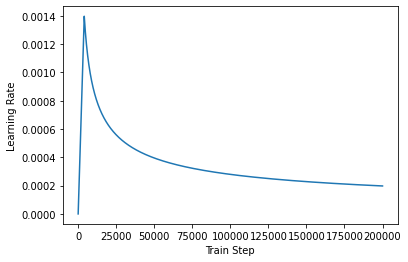

In [253]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#### 4) 모델 컴파일
---

손실함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일한다.

In [254]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

#### 5) 훈련하기

In [255]:
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
168/168 [==============================] - 10s 30ms/step - loss: 4.8396 - accuracy: 0.1046
Epoch 2/10
168/168 [==============================] - 5s 30ms/step - loss: 3.9694 - accuracy: 0.1753
Epoch 3/10
168/168 [==============================] - 5s 30ms/step - loss: 3.3255 - accuracy: 0.1778
Epoch 4/10
168/168 [==============================] - 5s 30ms/step - loss: 3.0383 - accuracy: 0.1879
Epoch 5/10
168/168 [==============================] - 5s 30ms/step - loss: 2.8500 - accuracy: 0.1985
Epoch 6/10
168/168 [==============================] - 5s 30ms/step - loss: 2.6661 - accuracy: 0.2107
Epoch 7/10
168/168 [==============================] - 5s 30ms/step - loss: 2.4654 - accuracy: 0.2286
Epoch 8/10
168/168 [==============================] - 5s 30ms/step - loss: 2.2421 - accuracy: 0.2532
Epoch 9/10
168/168 [==============================] - 5s 30ms/step - loss: 1.9957 - accuracy: 0.2814
Epoch 10/10
168/168 [==============================] - 5s 30ms/step - loss: 1.7394 - accur

## 5) 챗봇 테스트하기
---

- 예측(inference)단계는 기본적으로 다음 과정을 거친다.

1) 새로운 입력 문장에 대해서 훈련때와 동일한 전처리를 거친다.<br>
2) 입력 문장을 토크나이징하고, `START_TOKEN`과 `END_TOKEN`을 추가한다.<br>
3) 패딩 마스킹과 룩어헤드 마스킹을 계산한다.<br>
4) 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.<br>
5) 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.<br>
6) `END_TOKEN`이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.<br>

<br>

위 과정을 모두 담은 `decoder_inference()` 함수를 만든다.

In [256]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 만듭니다.

In [257]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence


임의의 문장으로부터 챗봇의 대답을 얻어봅시다.

In [267]:
import random

for i in range(30):
    idx = random.randint(1, 6000)
    sentence_generation(questions[idx])
    print('\n')

입력 : 친구 좀 사귀고 싶다
출력 : 먼저 연락해보세요 .


입력 : 눈이 너무 많이 와
출력 : 저도 듣고 싶네요 .


입력 : 생강차 끓여 먹어야겠다
출력 : 저도 좋아해요 .


입력 : 눈 쌓였어
출력 : 맛있게 드세요 .


입력 : 요가하는데 아줌마들이 참견해
출력 : 그런 일이 있었나봐요 .


입력 : 끝내는게 맞을까
출력 : 그게 제일 중요한 것 같아요 .


입력 : 매콤한 닭발 생각나
출력 : 저도 듣고 싶네요 .


입력 : 씻고 자야 되는데
출력 : 그 사람도 그럴 거예요 .


입력 : 숏컷 해볼까 ?
출력 : 같이 가는 대로 해보세요 .


입력 : 직장에서 화풀이 대상 같은데 그만둬야 할까 ?
출력 : 저도 듣고 싶네요 .


입력 : 저금통 털까
출력 : 잘 찾아보세요 .


입력 : 오로라 보러 여행 가고 싶다
출력 : 저도 좋아해요 .


입력 : 조별 과제 발표 하기 싫어
출력 : 잘 찾아보세요 .


입력 : 아이라이너 그리기 귀찮은데 문신할까 ?
출력 : 저는 위로봇입니다 .


입력 : 먼지 지수 어때
출력 : 저도 듣고 싶네요 .


입력 : 남자인지 여자인지 알려줘
출력 : 저도 듣고 싶네요 .


입력 : 발표할때 너무 떨려
출력 : 맛있게 드세요 .


입력 : 발 부었어
출력 : 저도 듣고 싶네요 .


입력 : 최저시급은 받니
출력 : 많이 만나보세요 .


입력 : 피씨방 가자고 말해볼까 ?
출력 : 말해보세요 .


입력 : 돌잔치 가야지
출력 : 더 열심히 하면 돼요 .


입력 : 이자 왜 이렇게 많지 ?
출력 : 많이 만나보세요 .


입력 : 와 체육대회다
출력 : 맛있게 드세요 .


입력 : 내 의지는 상관없나봐
출력 : 더 많이 읽어보세요 .


입력 : 출근길 너무 힘들어
출력 : 잘 지내고 있을 거예요 .


입력 : 결혼식 또 가야돼
출력 : 안 맞았나봐요 .


입력 : 직장인도 방학 필요해
출력 : 저도 듣고 싶네요 .


입력 : 내여잘 건드린놈들
출력 : 그 사람도 그럴 거예

# 6) 결론

- 한국어 데이터로 챗봇 만들기 프로젝트를 진행하였다. 데이터셋은 질문/답변의 형식을 갖추고 있는 csv 형태의 파일이였으며 총 11832개의 데이터가 있었다. 전처리를 수행하였고,  SubwordTextEncoder를 사용하여 Tokenizer를 진행하였다. 데이터의 평균적인 토큰의 분포를 통계 데이터를 이용하여 파악하였고, 문장의 최대 길이 12개의 단어로 선정 후 패딩을 진행하였다.

- 트랜스포머 모델을 정의하기 위해 Positional Encoding / Scaled Dot Product Attention / Multi Head Attention / Padding Mask / Look Ahead Mask / Incoder / Decoder 함수 및 클래스를 정의하였다. 아직 Tensorflow 프레임워크를 사용하는데 많이 미숙하다. 각각의 함수들이 의미하는 게 무엇인지 활용은 어떻게 하면 되는지 찾아보면서 공부를 수행하다 보니, 정말 이번 노드는 오래 걸린 것 같다. 사실 아직 완벽하게 숙지하지 못한 내용이 많다... 그래도 새로운 모델 트랜스포머를 직접 설계해보고 평가까지 진행하며 많이 배웠다.

- 챗봇의 데이터 성능은 그럴듯하면서도 많이 어색한 답변을 하는경우도 여럿 있었다. 